# Analyzing @LADOTofficial tweets

#### Notes
Application LADOT uses to integrate social media platforms in one place:<br>
__Hootsuite__ https://www.youtube.com/watch?v=Ztk6PXD1EjU

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import json
import spacy
import sys

import requests
from requests import get

import time 
from time import sleep
import tqdm
from tqdm import trange
from IPython.core.display import clear_output

sys.path.insert(1, 'src/')
import acquire

## Wrangle

In [2]:
df = acquire.get_twitter_data()

print(df.shape)
df.head()

(172, 11)


,post_time,id,name,username,tweet,retweet_count,reply_count,like_count,quote_count,tweet_url_id,total_engagement
0,2020-09-30 16:02:18+00:00,61261275,Los Angeles Department of Transportation,LADOTofficial,a new bus-only lane is making its debut in #do...,27,9,111,8,1311335571097300996,155
1,2020-09-30 17:37:02+00:00,341250146,Joe Buscaino,JoeBuscaino,rt @bsslosangeles: what a difference it makes ...,3,0,0,0,1311359411806375936,3
2,2020-09-30 17:37:59+00:00,341250146,Joe Buscaino,JoeBuscaino,rt @losangeleswalks: safe streets organizing t...,3,0,0,0,1311359653037527040,3
3,2020-09-30 18:57:42+00:00,17070113,Eric Garcetti,MayorOfLA,rt @citylajobs: the city of la offers an onlin...,17,0,0,0,1311379712439058432,17
4,2020-09-30 19:10:52+00:00,893602974,"Curren D. Price, Jr.",CurrenDPriceJr,i partnered with guardaheart to bring crucial ...,0,0,1,1,1311383024559218688,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   post_time         172 non-null    object
 1   id                172 non-null    int64 
 2   name              172 non-null    object
 3   username          172 non-null    object
 4   tweet             172 non-null    object
 5   retweet_count     172 non-null    int64 
 6   reply_count       172 non-null    int64 
 7   like_count        172 non-null    int64 
 8   quote_count       172 non-null    int64 
 9   tweet_url_id      172 non-null    int64 
 10  total_engagement  172 non-null    int64 
dtypes: int64(7), object(4)
memory usage: 14.9+ KB


In [4]:
df.describe(include=np.number)

,id,retweet_count,reply_count,like_count,quote_count,tweet_url_id,total_engagement
count,1.720000e+02,172.000000,172.000000,172.000000,172.000000,1.720000e+02,172.000000
mean,1.150536e+08,911.831395,55.186047,325.610465,20.488372,1.313716e+18,1313.116279
std,2.299233e+08,10760.995030,256.603319,1341.121131,157.049830,1.647203e+15,10933.205177
min,1.707011e+07,0.000000,0.000000,0.000000,0.000000,1.311336e+18,0.000000
25%,1.707011e+07,2.000000,0.000000,0.000000,0.000000,1.312118e+18,6.000000
50%,1.707011e+07,14.000000,2.500000,7.500000,0.000000,1.313890e+18,34.000000
75%,6.126128e+07,37.250000,33.250000,104.250000,4.250000,1.314982e+18,206.250000
max,9.567633e+08,141061.000000,3156.000000,11722.000000,2015.000000,1.316485e+18,141061.000000


In [5]:
df.describe(exclude=np.number)

,post_time,name,username,tweet
count,172,172,172,172
unique,167,5,5,172
top,2020-10-12 20:01:00+00:00,Eric Garcetti,MayorOfLA,let's get counted! complete the #2020census to...
freq,2,100,100,1


In [6]:
df['is_parking_enforcement'] = np.where(df.tweet.str.contains('parking enforcement'), 1, 0)
df = df.drop(columns=['id', 'tweet_url_id'])

In [7]:
LADOT_tweets = df.loc[df.username == 'LADOTofficial'].reset_index(drop=True)

In [8]:
non_enforcement_tweets = df.loc[~df.tweet.str.contains('parking enforcement')]
enforcement_tweets = df.loc[df.tweet.str.contains('parking enforcement')]

non_enforcement_metrics = non_enforcement_tweets[['post_time', 'total_engagement']]
enforcement_metrics = enforcement_tweets[['post_time', 'total_engagement']]

non_enforcement_metrics.set_index('post_time', inplace=True)
enforcement_metrics.set_index('post_time', inplace=True)

non_enforcement_metrics.index = pd.to_datetime(non_enforcement_metrics.index)
enforcement_metrics.index = pd.to_datetime(enforcement_metrics.index)

In [9]:
enforcement_metrics = enforcement_metrics.resample('D').sum()
non_enforcement_metrics = non_enforcement_metrics.resample('D').sum()

# Exploration

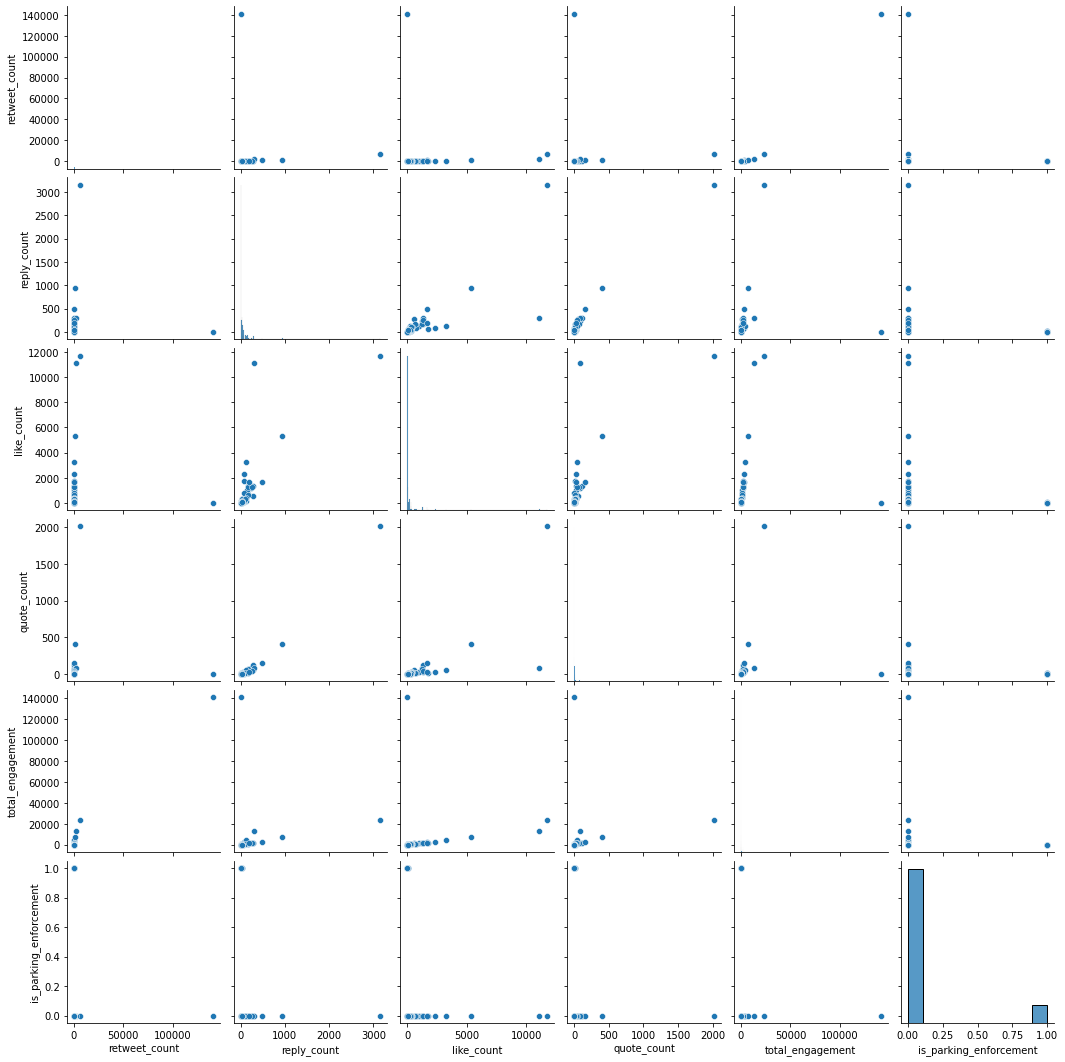

In [10]:
sns.pairplot(df);

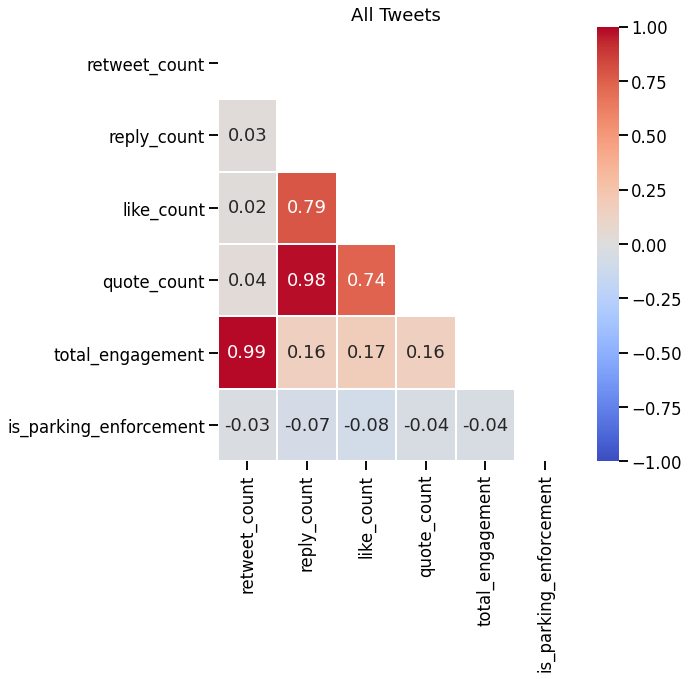

In [11]:
df_corrs = df.corr()
mask = np.zeros_like(df_corrs)
mask[np.triu_indices_from(mask)] = True

sns.set_context('talk')

plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(),
            linewidths=1,
            annot=True,
            cmap='coolwarm',
            fmt='.2f',
            vmax=1,
            vmin=-1,
            mask=mask)

plt.title('All Tweets');

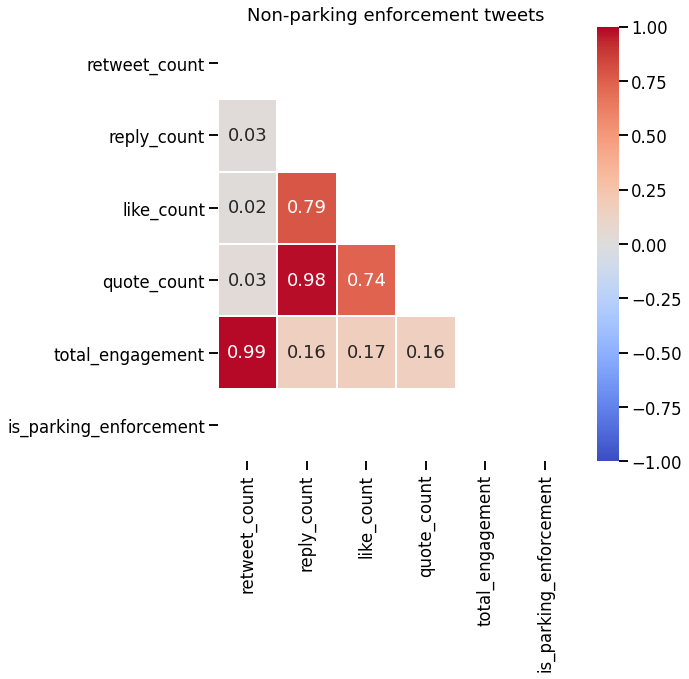

In [14]:
sns.set_context('talk')

plt.figure(figsize=(8, 8))
sns.heatmap(non_enforcement_tweets.corr(),
            linewidths=1,
            annot=True,
            cmap='coolwarm',
            fmt='.2f',
            mask=mask,
            vmax=1,
            vmin=-1)

plt.title('Non-parking enforcement tweets');

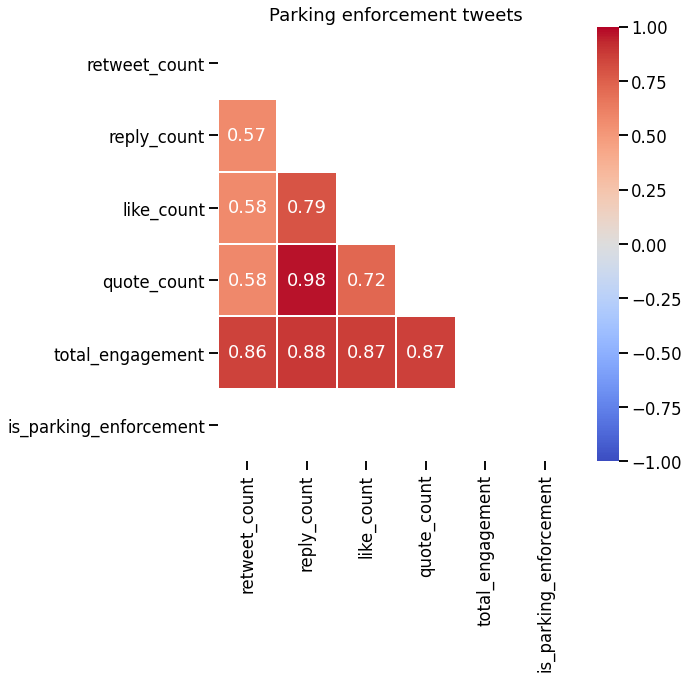

In [15]:
sns.set_context('talk')

plt.figure(figsize=(8, 8))
sns.heatmap(enforcement_tweets.corr(),
            linewidths=1,
            annot=True,
            cmap='coolwarm',
            mask=mask,
            vmax=1,
            vmin=-1)

plt.title('Parking enforcement tweets');

## Tweets from 09-30-2020 to 10-15-2020

In [16]:
df.is_parking_enforcement.value_counts(normalize=True)

0    0.895349
1    0.104651
Name: is_parking_enforcement, dtype: float64

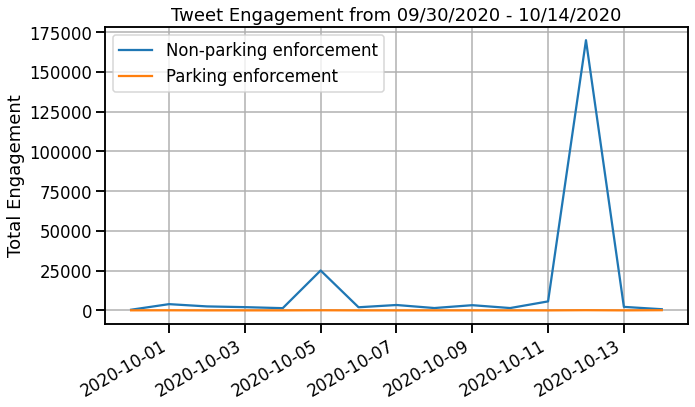

In [17]:
sns.set_context('talk')
plt.figure(figsize=(10, 6))

sns.lineplot(data=non_enforcement_metrics,
             x='post_time',
             y='total_engagement',
             label='Non-parking enforcement')


sns.lineplot(data=enforcement_metrics,
             x='post_time',
             y='total_engagement',
             label='Parking enforcement')


plt.title("Tweet Engagement from 09/30/2020 - 10/14/2020")
plt.xlabel('')
plt.ylabel('Total Engagement')

plt.xticks(rotation=30, ha="right")

plt.grid()
plt.tight_layout();

## Who tweeted the most about "parking enforcement"?

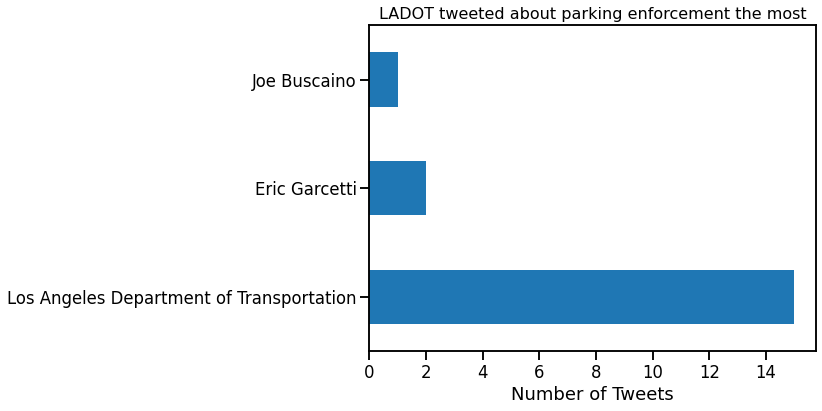

In [18]:
sns.set_context('talk')
enforcement_tweets.groupby('name').size().sort_values(ascending=False).plot.barh(figsize=(8, 6))

plt.title('LADOT tweeted about parking enforcement the most', fontsize=16)
plt.xlabel('Number of Tweets')
plt.ylabel('');

## Who generated the most engagement related to "parking enforcement"?

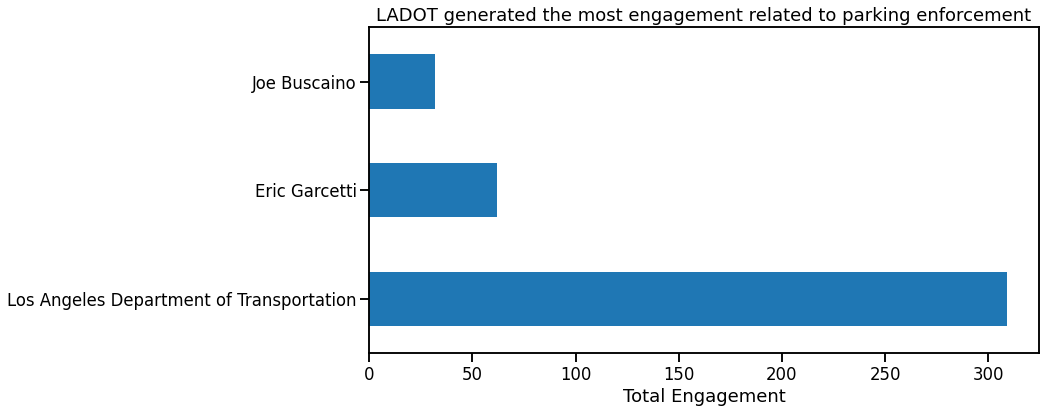

In [19]:
sns.set_context('talk')
enforcement_tweets.groupby('name').total_engagement.sum().sort_values(ascending=False).plot.barh(figsize=(12, 6))

plt.title('LADOT generated the most engagement related to parking enforcement', fontsize=18)
plt.xlabel('Total Engagement')
plt.ylabel('');

In [20]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 27.0 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [22]:
import spacy

nlp = spacy.load('en_core_web_sm')
sentence = ' '.join(enforcement_tweets.tweet)

doc = nlp(sentence)

ModuleNotFoundError: No module named 'thinc.types'

In [ ]:
from wordcloud import WordCloud

sentence = ' '.join(enforcement_tweets.tweet)

img = WordCloud(background_color='white').generate(sentence)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

# Conclusions

During the period of 09-30-2020 to 10-15-2020, LADOT created the most tweets related to parking enforcement. Of the tweets related to parking enforcement, LADOT generated the most engagement with Angelenos.

# Appendix

In [ ]:
non_enforcement_tweets.groupby('name').size().sort_values(ascending=False).plot.barh()
plt.ylabel('');

In [ ]:
non_enforcement_tweets.groupby('name').total_engagement.sum().sort_values(ascending=False).plot.barh()

plt.ylabel('');

In [ ]:
sns.set_context('talk')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

sns.lineplot(data=enforcement_metrics,
             x='post_time',
             y='total_engagement',
             label='Parking Enforcement',
             color='orange',
             ax=ax2)

sns.lineplot(data=non_enforcement_metrics,
             x='post_time',
             y='total_engagement',
             label='Non-parking Enforcement',
             ax=ax1)

ax1.grid()
ax2.grid()

ax1.get_xaxis().set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=8))
ax1.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %d %Y"))
plt.setp(ax1.get_xticklabels(), rotation=30, ha="right")

ax2.get_xaxis().set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=8))
ax2.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %d %Y"))
plt.setp(ax2.get_xticklabels(), rotation=30, ha="right")

ax1.set_ylim(0, 180_000)
ax2.set_ylim(0, 550)

ax1.set_xlabel('')
ax2.set_xlabel('')

ax1.set_ylabel('Total Engagement')
ax2.set_ylabel('')

plt.tight_layout();